In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
import seaborn as sns
import os
import glob

current_folder = os.getcwd()

csv_files = glob.glob(os.path.join(current_folder, "*.csv"))
csv_files.sort()
df_list = []
df_list_calibration = []
file_list = []
file_list_calibration = []


for file in csv_files:
    print(f"Processing: {file[-27:-4]}")

    
    df_header = pd.read_csv(file, delimiter=';', nrows=0)

    
    df = pd.read_csv(
        file,
        delimiter=';',
        decimal=',',
        skiprows=999,
        skipfooter=999,
        names=df_header.columns,
        engine='python'
    )
    if file.endswith('calibration.csv'):
        df_list_calibration.append(df)
        file_list_calibration.append(file)
    else:
        df_list.append(df)
        file_list.append(file)

print(f"Le nombre de fichiers 'calibration' : {len(df_list_calibration)}")
print(f"Le nombre de fichiers 'mesures' : {len(df_list)}")


Processing: 16_WL2m_4cm_calibration
Processing: L2m_10cmbis_calibration
Processing: _WL1,2m_4cm_calibration
Processing: ,2m_10cmbis_calibration
Processing: 12_WL2m_4cm_calibration
Processing: L2m_10cmbis_calibration
Processing: Pente_05_wl1,5m_h__04cm
Processing: Pente_05_wl1,5m_h__07cm
Processing: Pente_05_wl1,5m_h__10cm
Processing: Pente_05_wl1,5m_hb_10cm
Processing: Pente_05_wl2,0m_h__04cm
Processing: Pente_05_wl2,0m_h__07cm
Processing: Pente_05_wl2,0m_h__10cm
Processing: Pente_05_wl2,0m_hb_10cm
Processing: Pente_10_wl1,5m_h__04cm
Processing: Pente_10_wl1,5m_h__07cm
Processing: Pente_10_wl1,5m_h__10cm
Processing: Pente_10_wl1,5m_hb_10cm
Processing: Pente_10_wl2,0m_h__04cm
Processing: Pente_10_wl2,0m_h__07cm
Processing: Pente_10_wl2,0m_h__10cm
Processing: Pente_10_wl2,0m_hb_10cm
Le nombre de fichiers 'calibration' : 6
Le nombre de fichiers 'mesures' : 16


In [2]:
def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs  
    normal_cutoff = cutoff / nyquist 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order)
    return filtfilt(b, a, data)

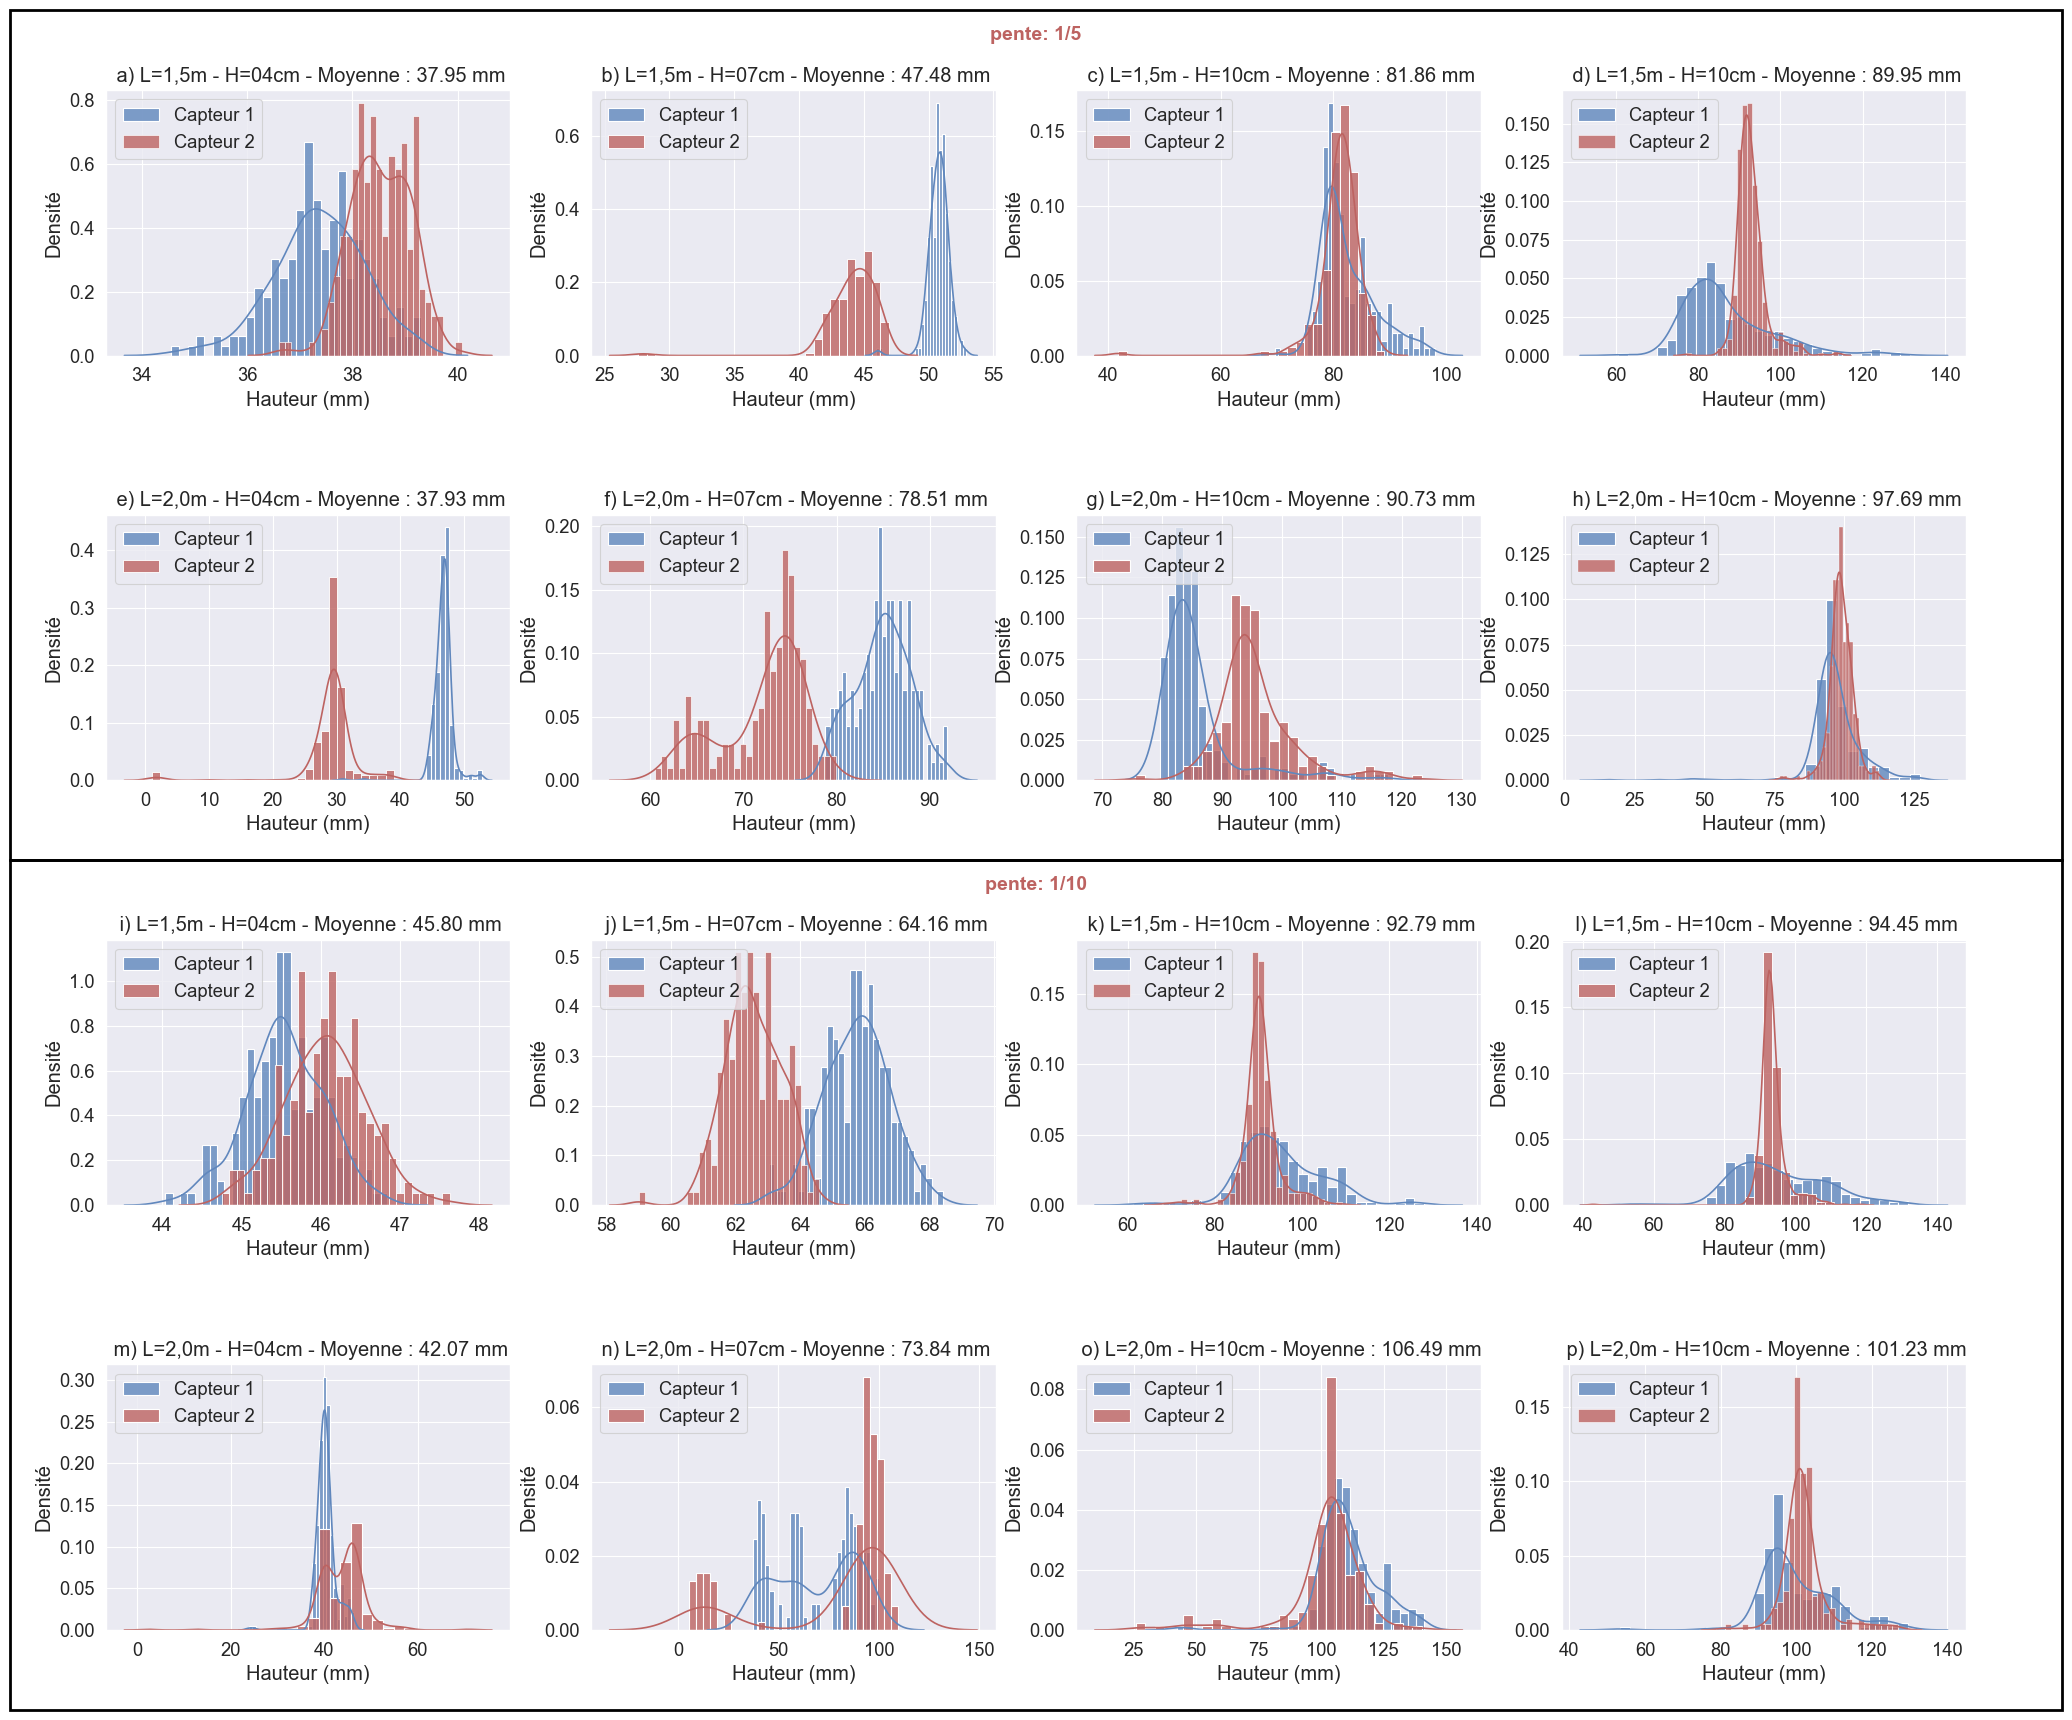

In [3]:
import math
import matplotlib.patches as patches


n = len(df_list)
ncols = 4
nrows = math.ceil(n / ncols)
sns.set_theme()
sns.set_context("paper",font_scale=1.5)
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
plt.subplots_adjust(hspace=0.6) 
axes = axes.flatten()  


for i,df in enumerate(df_list):    
    
    letters= ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)','k)','l)','m)','n)','o)','p)']     
    list_sensore = ["Sensore_5[mm]","Sensore_6[mm]"]
    list_wave_heights = []
    list_zero_up_crossing = []
    list_zero_down_crossing = []
    list_signal = []
    
    for j in list_sensore:

        dff = df.copy()[j][8000:] # pour éviter les premières secondes où les capteurs fluctuent
        dff = dff.mask((dff < 350) | (dff > 545))
        
        df_1 = dff.interpolate(method='linear')
        df_zc = df_1.copy()[20:-20] # car valeurs aberrantes (<0) après l'interpolation sur les bords
        df_zc = pd.DataFrame(df_zc)  

        # Paramètres du filtre, vient de la fréquence des capteurs
        fs = 100  
        cutoff = 2

        df_zc['filtered_signal'] = butter_lowpass_filter(df_zc[j], cutoff, fs)

        mean_value = df_zc['filtered_signal'].mean()
        df_zc['centered_signal'] = df_zc['filtered_signal'] - mean_value

        signal = df_zc['centered_signal'].values
        list_signal.append(signal)
        # Détection des zero-up crossings : test toutes les paires, 
        # où le signal passe d'une valeur négative à positive
        # signal[:-1] -> 0 à N-1 et signal[1:] -> 1 à N
        zero_up_crossings = np.where((signal[:-1] < 0) & (signal[1:] >= 0))[0]

        # Détection des zero-down crossings (de positif à négatif)
        zero_down_crossings = np.where((signal[:-1] > 0) & (signal[1:] <= 0))[0]

        list_zero_up_crossing.append(zero_up_crossings)
        list_zero_down_crossing.append(zero_down_crossings)

        wave_heights = []  # Liste pour stocker les hauteurs de vagues
        wave_indices = []  

        # Boucle sur chaque paire de zero-down crossings
        for k in range(len(zero_down_crossings) - 1):
            start = zero_down_crossings[k]
            end = zero_down_crossings[k + 1]
            
            # Extraire la portion de signal correspondant à une vague
            wave = signal[start:end]
            
            if len(wave) > 0:
                H = np.max(wave) - np.min(wave)  # Hauteur = crête - creux
                wave_heights.append(H)
                wave_indices.append((start, end))  
        wave_heights = np.array(wave_heights)
        list_wave_heights.append(wave_heights)
    
    
    crossings_1 = list_zero_up_crossing[0]
    crossings_2 = list_zero_up_crossing[1]
    
    with sns.axes_style("darkgrid"):
       
        palette = sns.color_palette("vlag",n_colors=8)
        
        sns.histplot(list_wave_heights[0], bins=30, stat="density",ax=axes[i], color=palette[0], alpha=0.8, label='Capteur 1')
        sns.kdeplot(list_wave_heights[0], color=palette[0],ax=axes[i])

        sns.histplot(list_wave_heights[1], bins=30, stat="density",ax=axes[i], color=palette[-1], alpha=0.8, label='Capteur 2')
        sns.kdeplot(list_wave_heights[1], color=palette[-1],ax=axes[i])
        axes[i].set_title(f" {letters[i]} L={file_list[i][-16:-12]} - H={file_list[i][-8:-4]} - Moyenne : {(list_wave_heights[0].mean()+list_wave_heights[1].mean())/2:.2f} mm")
        axes[i].set_xlabel("Hauteur (mm)")
        axes[i].set_ylabel("Densité")
        axes[i].legend(loc='upper left')
        axes[i].grid(True)
        

#plt.tight_layout(rect=[0, 0, 1, 0.95])
bbox_list_top = [axes[i].get_position() for i in range(8)]
x0_top = min(bbox.x0 for bbox in bbox_list_top)
y0_top = min(bbox.y0 for bbox in bbox_list_top)
x1_top = max(bbox.x1 for bbox in bbox_list_top)
y1_top = max(bbox.y1 for bbox in bbox_list_top)

margin_x = 0.04
margin_y = 0.04
x0_m_top = x0_top - margin_x
y0_m_top = y0_top - margin_y
x1_m_top = x1_top + margin_x
y1_m_top = y1_top + margin_y

width_top = x1_m_top - x0_m_top
height_top = y1_m_top - y0_m_top

rect_top = patches.Rectangle(
    (x0_m_top, y0_m_top), width_top, height_top,
    linewidth=2, edgecolor='black', facecolor='none',
    transform=fig.transFigure, zorder=5
)
fig.patches.append(rect_top)
fig.text(
    x0_m_top + width_top/2, y1_m_top-0.015,
    "pente: 1/5", color=palette[-1], fontsize=14, weight='bold',
    ha='center'
)

bbox_list_bottom = [axes[i].get_position() for i in range(8, 16)]
x0_bot = min(bbox.x0 for bbox in bbox_list_bottom)
y0_bot = min(bbox.y0 for bbox in bbox_list_bottom)
x1_bot = max(bbox.x1 for bbox in bbox_list_bottom)
y1_bot = max(bbox.y1 for bbox in bbox_list_bottom)

x0_m_bot = x0_bot - margin_x
y0_m_bot = y0_bot - margin_y
x1_m_bot = x1_bot + margin_x
y1_m_bot = y1_bot + margin_y

width_bot = x1_m_bot - x0_m_bot
height_bot = y1_m_bot - y0_m_bot

rect_bot = patches.Rectangle(
    (x0_m_bot, y0_m_bot), width_bot, height_bot,
    linewidth=2, edgecolor='black', facecolor='none',
    transform=fig.transFigure, zorder=5
)
fig.patches.append(rect_bot)
fig.text(
    x0_m_bot + width_bot/2, y1_m_bot-0.015 ,
    "pente: 1/10", color=palette[-1], fontsize=14, weight='bold',
    ha='center'
)

plt.savefig("All_data_log.png")
plt.show()


## Plot individuel, avec choix du graphe g) (pour le rapport final)

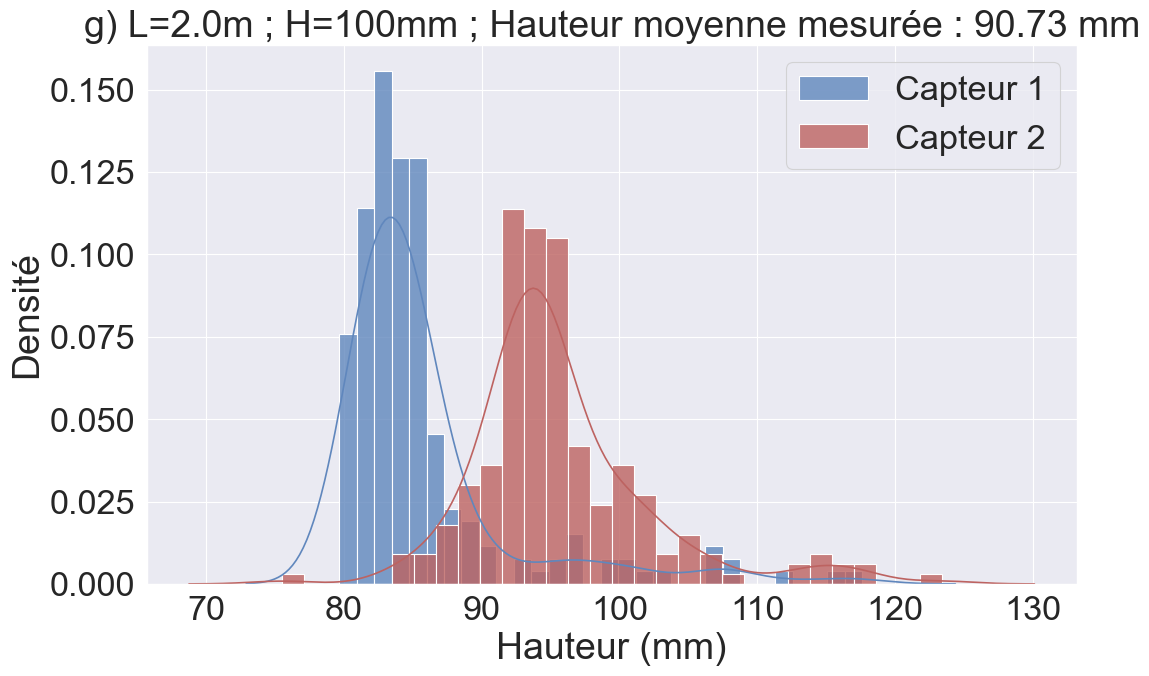

In [5]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import numpy as np
import pandas as pd

# Configuration pour un seul plot
i = 6  # L'index de l'image voulu
sns.set_theme()
sns.set_context("paper", font_scale=2.8)
fig, ax = plt.subplots(figsize=(12, 7))  # Taille adaptée à un seul graphique

letters = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)', 'm)', 'n)', 'o)', 'p)']
list_sensore = ["Sensore_5[mm]", "Sensore_6[mm]"]
list_wave_heights = []
list_zero_up_crossing = []
list_zero_down_crossing = []
list_signal = []

df = df_list[i]  # On ne garde que le DataFrame d'index 6

for j in list_sensore:
    dff = df.copy()[j][8000:]
    dff = dff.mask((dff < 350) | (dff > 545))
    df_1 = dff.interpolate(method='linear')
    df_zc = df_1.copy()[20:-20]
    df_zc = pd.DataFrame(df_zc)

    fs = 100
    cutoff = 2
    df_zc['filtered_signal'] = butter_lowpass_filter(df_zc[j], cutoff, fs)

    mean_value = df_zc['filtered_signal'].mean()
    df_zc['centered_signal'] = df_zc['filtered_signal'] - mean_value

    signal = df_zc['centered_signal'].values
    list_signal.append(signal)

    zero_up_crossings = np.where((signal[:-1] < 0) & (signal[1:] >= 0))[0]
    zero_down_crossings = np.where((signal[:-1] > 0) & (signal[1:] <= 0))[0]

    list_zero_up_crossing.append(zero_up_crossings)
    list_zero_down_crossing.append(zero_down_crossings)

    wave_heights = []
    for k in range(len(zero_down_crossings) - 1):
        start = zero_down_crossings[k]
        end = zero_down_crossings[k + 1]
        wave = signal[start:end]
        if len(wave) > 0:
            H = np.max(wave) - np.min(wave)
            wave_heights.append(H)
    list_wave_heights.append(np.array(wave_heights))

# Affichage
with sns.axes_style("darkgrid"):
    palette = sns.color_palette("vlag", n_colors=8)

    sns.histplot(list_wave_heights[0], bins=30, stat="density", ax=ax, color=palette[0], alpha=0.8, label='Capteur 1')
    sns.kdeplot(list_wave_heights[0], color=palette[0], ax=ax)

    sns.histplot(list_wave_heights[1], bins=30, stat="density", ax=ax, color=palette[-1], alpha=0.8, label='Capteur 2')
    sns.kdeplot(list_wave_heights[1], color=palette[-1], ax=ax)
    #ax.set_title(f"L={file_list[i][-16:-12]} ; H={file_list[i][-8:-4]} ; Hauteur mesurée : {(list_wave_heights[0].mean() + list_wave_heights[1].mean()) / 2:.2f} mm")
    ax.set_title(f"g) L=2.0m ; H=100mm ; Hauteur moyenne mesurée : 90.73 mm") # A changer selon le i choisi
    ax.set_xlabel("Hauteur (mm)")
    ax.set_ylabel("Densité")
    ax.legend(loc='upper right')
    ax.grid(True)

#plt.tight_layout()
plt.savefig("single_plot_i6_rapport.png")
plt.show()


## Plot individuel, avec choix du graphe i) (pour le rapport final)

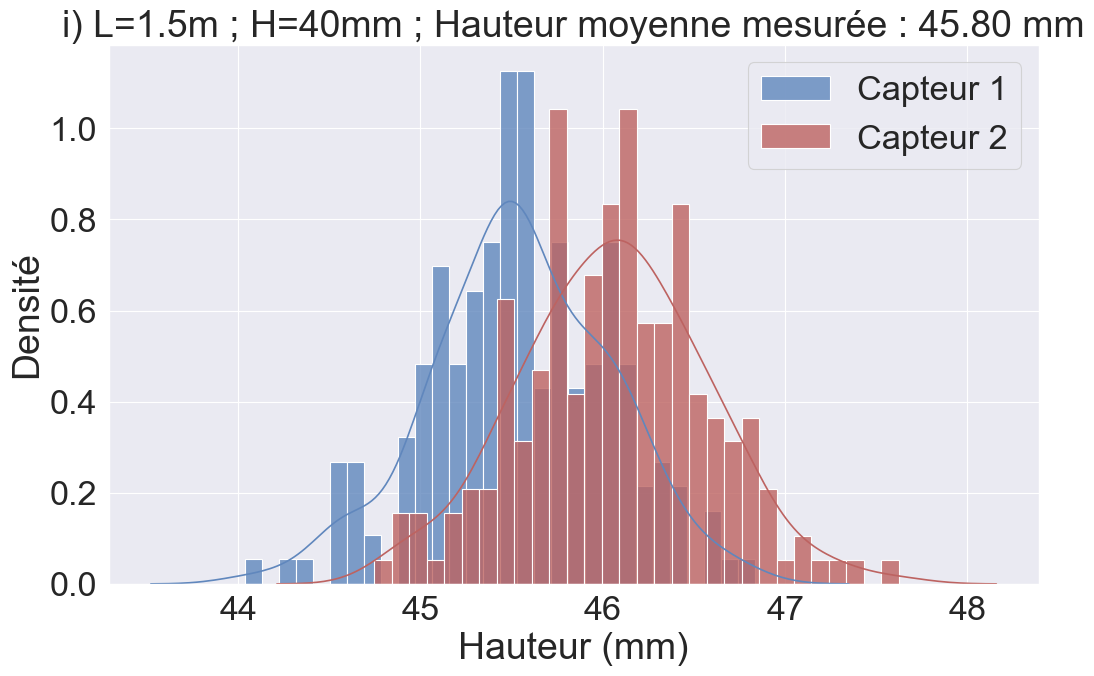

In [6]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import numpy as np
import pandas as pd

# Configuration pour un seul plot
i = 8  # L'index désiré
sns.set_theme()
sns.set_context("paper", font_scale=2.8)
fig, ax = plt.subplots(figsize=(12, 7))  

letters = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)', 'm)', 'n)', 'o)', 'p)']
list_sensore = ["Sensore_5[mm]", "Sensore_6[mm]"]
list_wave_heights = []
list_zero_up_crossing = []
list_zero_down_crossing = []
list_signal = []

df = df_list[i]  # On ne garde que le DataFrame d'index 6

for j in list_sensore:
    dff = df.copy()[j][8000:]
    dff = dff.mask((dff < 350) | (dff > 545))
    df_1 = dff.interpolate(method='linear')
    df_zc = df_1.copy()[20:-20]
    df_zc = pd.DataFrame(df_zc)

    fs = 100
    cutoff = 2
    df_zc['filtered_signal'] = butter_lowpass_filter(df_zc[j], cutoff, fs)

    mean_value = df_zc['filtered_signal'].mean()
    df_zc['centered_signal'] = df_zc['filtered_signal'] - mean_value

    signal = df_zc['centered_signal'].values
    list_signal.append(signal)

    zero_up_crossings = np.where((signal[:-1] < 0) & (signal[1:] >= 0))[0]
    zero_down_crossings = np.where((signal[:-1] > 0) & (signal[1:] <= 0))[0]

    list_zero_up_crossing.append(zero_up_crossings)
    list_zero_down_crossing.append(zero_down_crossings)

    wave_heights = []
    for k in range(len(zero_down_crossings) - 1):
        start = zero_down_crossings[k]
        end = zero_down_crossings[k + 1]
        wave = signal[start:end]
        if len(wave) > 0:
            H = np.max(wave) - np.min(wave)
            wave_heights.append(H)
    list_wave_heights.append(np.array(wave_heights))

# Affichage
with sns.axes_style("darkgrid"):
    palette = sns.color_palette("vlag", n_colors=8)

    sns.histplot(list_wave_heights[0], bins=30, stat="density", ax=ax, color=palette[0], alpha=0.8, label='Capteur 1')
    sns.kdeplot(list_wave_heights[0], color=palette[0], ax=ax)

    sns.histplot(list_wave_heights[1], bins=30, stat="density", ax=ax, color=palette[-1], alpha=0.8, label='Capteur 2')
    sns.kdeplot(list_wave_heights[1], color=palette[-1], ax=ax)
    ax.set_title(f"i) L=1.5m ; H=40mm ; Hauteur moyenne mesurée : 45.80 mm")
    ax.set_xlabel("Hauteur (mm)")
    ax.set_ylabel("Densité")
    ax.legend(loc='upper right')
    ax.grid(True)

#plt.tight_layout()
plt.savefig("single_plot_i8_rapport.png")
plt.show()
